<a href="https://colab.research.google.com/github/dineshy98/natural-language-processing/blob/master/transformers_language_trans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

KeyboardInterrupt: ignored

In [ ]:

import pandas as pd
import numpy as np
import re

english = []

for line in  open('/content/drive/My Drive/Datasets/Language_Translation/english.txt'):
    english.append(line)



french = []

for line in  open('/content/drive/My Drive/Datasets/Language_Translation/french.txt'):
    french.append(line)

data1 = pd.DataFrame(english,columns = ['english'])
data1['french'] = french

data = data1.copy()
data.columns = ['en','de']

In [ ]:
#1.Removing unwanted texts 
def clean_data(df_col):
    
    df_col = df_col.apply(lambda x : re.sub(r'[!@#$(),-."%^*?:;~`0-9]', '', str(x)))
    df_col = df_col.apply(lambda x : x.lower())
    df_col = df_col.apply(lambda x : " ".join(x.split()))
    
    
    return df_col

data['en'] = clean_data(data['en'])
data['de'] = clean_data(data['de'])



In [ ]:
def get_vocab(df_col):
    vocab_list = []
    for line in df_col:
        vocab_list.extend(line.split(' '))
        
    return list(set(vocab_list))

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences

def padding_vocabsize_object(df_col,decoder_bool):   
    
    tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(
        lower=True, split=' ', char_level=False, oov_token=None)
    
    tokenizer.fit_on_texts(df_col)
    sequences = tokenizer.texts_to_sequences(df_col)
    
    max_len = max([len(x) for x in sequences])
    
    if decoder_bool:
        max_len = max_len+1
    
    padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_len)
    
    return tokenizer,padded,max_len



en_t,en_padded,en_max_len = padding_vocabsize_object(data['en'],decoder_bool = False)
de_t,de_padded,de_max_len = padding_vocabsize_object(data['de'],decoder_bool = True)

de_padded_shifted = np.roll(de_padded, 1, axis=1)

In [ ]:
en_token_to_int = en_t.word_index
de_token_to_int = de_t.word_index

en_int_to_token = en_t.index_word
de_int_to_token = de_t.index_word


de_vocab_size = len(de_token_to_int)
en_vocab_size = len(en_token_to_int)
samples = len(data['en'])

decoder_target_data = np.zeros((samples, de_max_len, de_vocab_size+1),dtype='float32')

for sentence_number,sentence in enumerate(data['de']):
    for timestep,word in enumerate(sentence.split(' ')):
        decoder_target_data[sentence_number,timestep,de_token_to_int[word]] = 1

In [ ]:
import tensorflow
from tensorflow.keras.layers import Input,LSTM,Dense,Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Attention,AdditiveAttention

In [ ]:
#encoder
en_input = Input(shape = (en_max_len,) , name = 'encoder_input')
en_embedding = Embedding(input_dim = en_vocab_size+1,output_dim = 100,input_length = en_max_len)(en_input)
en_out,en_h,en_s = LSTM(5,return_state = True,return_sequences = True,name = 'encoder_lstm')(en_embedding)

en_states = [en_h,en_s]



#decoder
de_input = Input(shape = (de_max_len,) , name = 'decoder_input')
de_embedding = Embedding(input_dim = de_vocab_size+1,output_dim = 100,input_length = de_max_len)(de_input)
de_lstm = LSTM(5,return_state = True,return_sequences = True,name = 'decoder_lstm')
de_outs,de_hs,de_ss = de_lstm(de_embedding,initial_state = en_states)

decoder_dense = Dense(de_vocab_size+1,activation = 'softmax',name = 'decoder_dense')
decoder_outputs = decoder_dense(de_outs)




model = Model([en_input, de_input], decoder_outputs, name='model_encoder_training')

In [ ]:
model.compile(optimizer = 'adam',metrics = ['accuracy'],loss = 'categorical_crossentropy')
model.summary()

Model: "model_encoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 15)]         0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 15, 100)      20000       encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 22, 100)      34500       decoder_input[0][0]              
_____________________________________________________________________________

model.compile(optimizer = 'adam',metrics = ['accuracy'],loss = 'categorical_crossentropy')
model.summary()

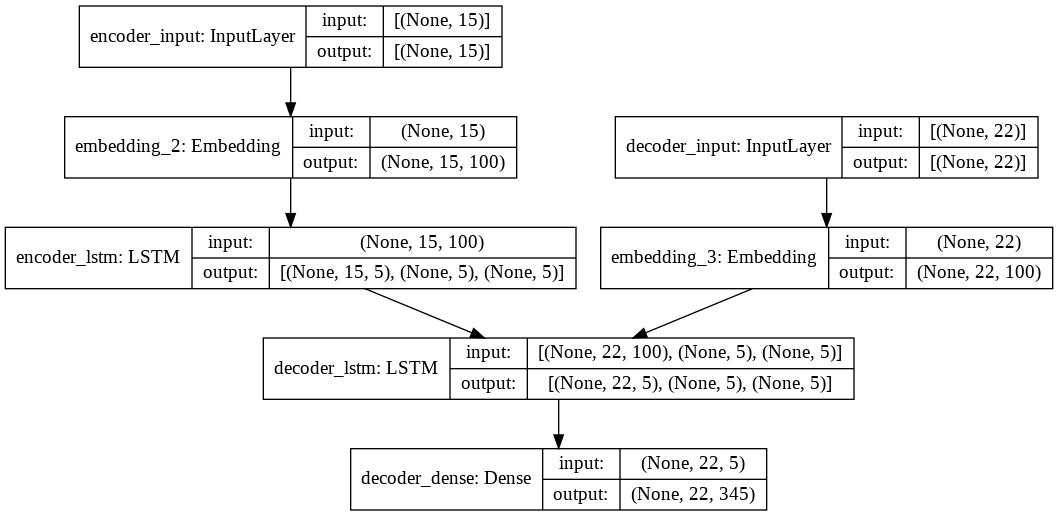

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.fit([en_padded, de_padded_shifted], decoder_target_data,
          batch_size=32,
          epochs=1000,
          validation_split=0.2)

Epoch 1/1000
3447/3447 [==============================] - 125s 24ms/step - loss: 2.3445 - accuracy: 0.0717 - val_loss: 2.1791 - val_accuracy: 0.0815
Epoch 2/1000
3447/3447 [==============================] - 81s 24ms/step - loss: 2.1180 - accuracy: 0.0857 - val_loss: 2.0656 - val_accuracy: 0.0899
Epoch 3/1000
3447/3447 [==============================] - 81s 24ms/step - loss: 2.0328 - accuracy: 0.0934 - val_loss: 1.9980 - val_accuracy: 0.0978
Epoch 4/1000
3447/3447 [==============================] - 80s 23ms/step - loss: 1.9635 - accuracy: 0.1007 - val_loss: 1.9329 - val_accuracy: 0.1075
Epoch 5/1000
3447/3447 [==============================] - 80s 23ms/step - loss: 1.9065 - accuracy: 0.1128 - val_loss: 1.8827 - val_accuracy: 0.1171
Epoch 6/1000
3447/3447 [==============================] - 81s 24ms/step - loss: 1.8675 - accuracy: 0.1179 - val_loss: 1.8506 - val_accuracy: 0.1178
Epoch 7/1000
3447/3447 [==============================] - 81s 23ms/step - loss: 1.8412 - accuracy: 0.1193 - val